# Prediction of dynamical systems

**Author:** M.G. Baltussen

**Estimated running time:** 20 minutes (including compilation of the Amici module, this can be disabled after the first run)

**Generated output:**
```
plots/dynamics_predictions.{svg,png} (manuscript figure 3)
plots/dynamics_score.{svg,png} (manuscript figure 3)

plots_extended/si_dynamics_full.{svg,png}
plots_extended/si_dynamics_predictions_a.{svg,png}
plots_extended/si_dynamics_predictions_b.{svg,png}
plots_extended/si_dynamics_errors.{svg,png}

./CCM_ext_Gly_mod.xml (downloaded by the notebook from [biomodels.com](https://www.ebi.ac.uk/biomodels/))
./amici-CCM_ext_Gly_mod (generated folder, contains Amici-compiled C++ model)
```

## Imports

In [1]:
""" System imports """
import pathlib
import toml

""" Essential imports"""
import numpy as np
import pandas as pd

""" ML/RC imports """
from sklearn.feature_selection import mutual_info_regression as mi_reg
from sklearn import linear_model, model_selection, preprocessing, svm
from sklearn import metrics

from pyrcn.echo_state_network import ESNClassifier


""" Visualization imports and settings"""
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns; sns.set_theme(style='ticks', context='paper', font_scale=0.75, 
rc={
    "axes.linewidth": 0.5,     
    'axes.facecolor':'#eceff4', 
    'axes.edgecolor':'#2e3440',
    'axes.labelcolor':'#2e3440',
    'text.color': '#2e3440',
    'xtick.color': '#2e3440',
    'ytick.color': '#2e3440',
    'font.family': 'Arial',
    'svg.fonttype': 'none',
    })
import colorcet as cc

nord_palette = [
    "#bf616a","#d08770","#ebcb8b","#a3be8c","#b48ead",
    "#8fbcbb","#88c0d0","#81a1c1","#5e81ac",
    "#2e3440","#3b4252","#434c5e","#4c566a",
    "#d8dee9","#e5e9f0","#eceff4",
]

sns.set_palette(nord_palette)

def save_plot(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots/{name}.svg", **kwargs)
    plt.savefig(f"../plots/{name}.png", dpi=600, **kwargs)

def save_si(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots_extended/{name}.svg", **kwargs)
    plt.savefig(f"../plots_extended/{name}.png", dpi=600, **kwargs)


## Data loading

In [2]:
df_all = pd.read_csv("../data/fluctuations.csv", index_col=0)
df_all.index = df_all.index / 60 # minutes
U_fluctuations = df_all['DHA']

X = df_all.drop(columns=['DHA', 'NaOH', 'CaCl2', 'formaldehyde'])

## Plots figure 3b

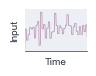

In [3]:
fig, axes = plt.subplots(figsize=(0.85, 0.65), constrained_layout=True)

axes.plot(U_fluctuations.index[:720], U_fluctuations.values[:720], alpha=1.0, lw=0.5, color='#b48ead')

axes.set_xticks([0, 1800, 3600, 7200, 10800], [0, 0.5, 1, 2, 3])
axes.set_xticks([])
axes.set_xlim(40, 80)
axes.set_yticks([50, 30, 10], ['DHA', r'$\rm{CaCl}_2$', 'Form.'])
axes.set_yticks([])
axes.set_xlabel("Time")
axes.set_ylabel("Input")

sns.despine(left=True)
save_plot("dynamics_input")
plt.show()

# Load/modify/compile SBML model

In [4]:
import tellurium as te
import amici
import libsbml

r = te.loadSBMLModel('https://ftp.ebi.ac.uk/pub/databases/biomodels/repository/aaj/MODEL2010160002/3/CCM_ext_Gly.xml') # E. coli glycerol Oliveira 2020

r.addParameter("kf", 1.0)
for s, c in zip(r.getFloatingSpeciesIds(), r.getFloatingSpeciesConcentrations()):
    r.addSpeciesConcentration(f"{s}_in", compartment='cell', initConcentration=c, boundaryCondition=True)
    r.addReaction(f"F_{s}_in", [], [s], f"kf*{s}_in")
    r.addReaction(f"F_{s}_out", [s], [], f"kf*{s}")
r.exportToSBML("CCM_ext_Gly_mod.xml")


In [5]:
sbml_doc = libsbml.SBMLReader().readSBML('CCM_ext_Gly_mod.xml')
sbml_model = sbml_doc.getModel()

sbml_importer = amici.SbmlImporter(sbml_model)

sbml_importer.sbml2amici(model_name="CCM_ext_Gly_mod", output_dir='amici-CCM_ext_Gly_mod', verbose=True, compile=True) # If module has been compiled before, this line can be disable to skip compilation
model_module = amici.import_model_module("CCM_ext_Gly_mod", "amici-CCM_ext_Gly_mod")
model = model_module.getModel()

ORIGINAL_STATES = model.getInitialStates()

### Pre-equilibration

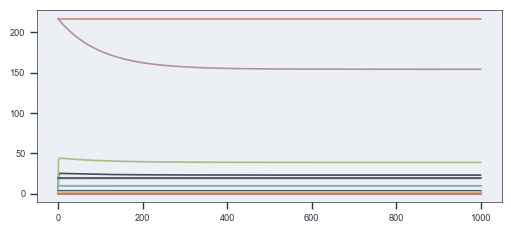

In [6]:
initial_states = list(ORIGINAL_STATES)
initial_states[-1] = 2
model.setInitialStates(initial_states)

solver = model.getSolver()

model.setParameterByName('kf', 0.9)
model.setTimepoints(np.linspace(0, 1000, 1000))
rdata = amici.runAmiciSimulation(model, solver)

fig, axes = plt.subplots(figsize=(6,2.5))
axes.plot(rdata['t'], rdata['x'])
plt.show()

## Calculate *In silico* target functions 

In [7]:
solver = model.getSolver()
model.setParameterByName('kf', 0.8)
model.setInitialStates(rdata['x'][-1])
model.setTimepoints(np.linspace(0, 10, 1000))
rdata = amici.runAmiciSimulation(model, solver)

time_points = np.linspace(U_fluctuations.index[0], U_fluctuations.index[-1], len(U_fluctuations))
data_points = []

""" Only start a new flow every 60 seconds, because flows were held constant inbetween"""
for time, DHA in U_fluctuations[::6].items():
    model.setTimepoints(np.linspace(0, 1, 6))
    initial_states = rdata['x'][-1]
    initial_states[-1] = DHA
    model.setInitialStates(initial_states)
    rdata = amici.runAmiciSimulation(model, solver)

    data_points.append(rdata['x'][:, :87])

data = np.array(data_points).reshape(203*6, 87)


### Plot target functions

In [8]:
model.getStateIds

<bound method ModelPtr.getStateIds of <amici.amici.ModelPtr; proxy of <Swig Object of type 'std::unique_ptr< amici::Model > *' at 0x7f9cfed06a60> >>

In [9]:
data = pd.DataFrame(data=data, columns=model.getStateIds()[:87], index=time_points)

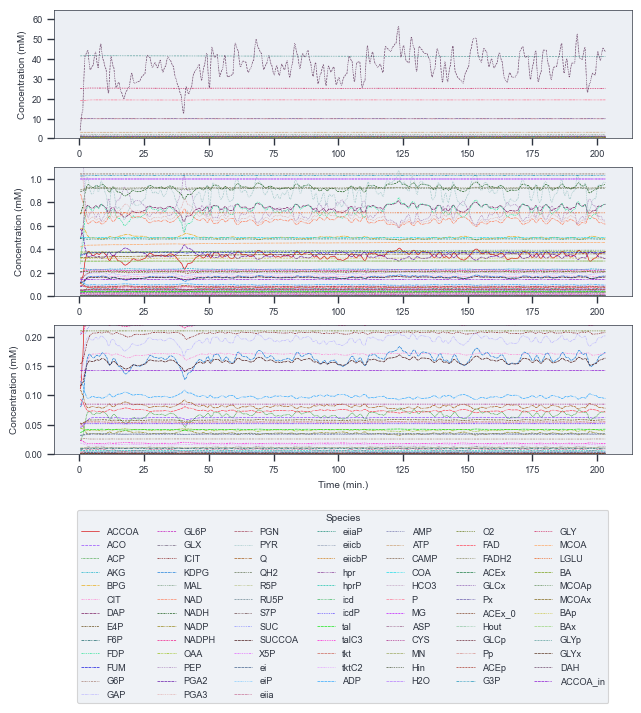

In [10]:
fig, axes = plt.subplots(3, figsize=(6.3,7), constrained_layout=True)

sns.lineplot(ax=axes[0], data=data, palette=cc.glasbey_dark[:data.shape[1]], lw=0.5, alpha=0.9, legend=None)
sns.lineplot(ax=axes[1], data=data, palette=cc.glasbey_dark[:data.shape[1]], lw=0.5, alpha=0.9, legend=None)
sns.lineplot(ax=axes[2], data=data, palette=cc.glasbey_dark[:data.shape[1]], lw=0.5, alpha=0.9)
# axes[0].plot(time_points, data, color=cc.glasbey_dark[:data.shape[1]])
# axes[1].plot(time_points, data, color=cc.glasbey_dark[:data.shape[1]])
# axes[2].plot(time_points, data, color=cc.glasbey_dark[:data.shape[1]])

axes[0].set_ylim(0, 65)
axes[1].set_ylim(0, 1.1)
axes[2].set_ylim(0, 0.22)

axes[2].set_xlabel("Time (min.)")
axes[0].set_ylabel("Concentration (mM)")
axes[1].set_ylabel("Concentration (mM)")
axes[2].set_ylabel("Concentration (mM)")

axes[2].legend(ncols=7, title='Species', loc='upper center', bbox_to_anchor=(0.5, -0.4))

plt.show()

## Training and plots with total results


invalid value encountered in scalar divide



invalid value encountered in scalar divide



invalid value encountered in scalar divide



invalid value encountered in scalar divide



invalid value encountered in scalar divide



invalid value encountered in scalar divide



invalid value encountered in scalar divide



invalid value encountered in scalar divide



invalid value encountered in scalar divide




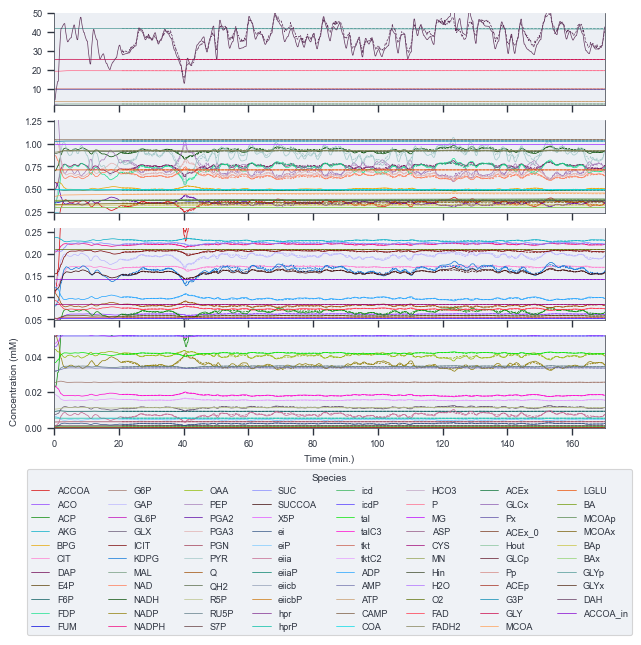

In [11]:
fig, axes = plt.subplots(4, figsize=(6.3,6.3), sharex=True, constrained_layout=True, gridspec_kw={
                            'hspace': -0.33,})

def nmse(y_pred, y_true):
    return ((y_pred - y_true)**2).sum()/((y_true - y_true.mean())**2).sum()

N_skip = 100 + 18
N_train = 300-2
N_test = 1019



data_test = []
data_test_lin = []
MSE_tests = []
MSE_lin_tests = []

for i, s in enumerate(model.getStateIds()[:87]):
    Y_train = data.values[N_skip:N_train, i]
    X_train = X.iloc[N_skip-4:N_train-4]

    Y_test = data.values[N_train:N_test, i]

    reg = linear_model.Ridge(alpha=0.00005)
    reg_lin = linear_model.Ridge(alpha=0.00005)

    reg.fit(X_train, Y_train)
    reg_lin.fit(U_fluctuations.values[N_skip-6:N_train-6].reshape(-1, 1), Y_train)

    Y_pred = reg.predict(X.iloc[N_skip:N_test])
    train_mse = nmse(reg.predict(X_train), Y_train)
    test_mse = nmse(Y_pred, data.values[N_skip+6:N_test+6,i])
    data_test.append(Y_pred)
    MSE_tests.append(test_mse)

    
    Y_pred_lin = reg_lin.predict(U_fluctuations.iloc[N_skip:N_test].values.reshape(-1, 1))
    test_mse_lin = nmse(Y_pred_lin, data.values[N_skip+6:N_test+6,i])

    data_test_lin.append(Y_pred_lin)
    MSE_lin_tests.append(test_mse_lin)


    axes[0].plot(time_points[N_skip+6:N_test+6], Y_pred, '--', lw=0.5, color=cc.glasbey_dark[i])
    axes[1].plot(time_points[N_skip+6:N_test+6], Y_pred, '--', lw=0.5, color=cc.glasbey_dark[i])
    axes[2].plot(time_points[N_skip+6:N_test+6], Y_pred, '--', lw=0.5, color=cc.glasbey_dark[i])
    axes[3].plot(time_points[N_skip+6:N_test+6], Y_pred, '--', lw=0.5, color=cc.glasbey_dark[i])

    axes[0].plot(time_points[:N_test], data.values[:N_test][:,i], lw=0.5, color=cc.glasbey_dark[i])
    axes[1].plot(time_points[:N_test], data.values[:N_test][:,i], lw=0.5, color=cc.glasbey_dark[i])
    axes[2].plot(time_points[:N_test], data.values[:N_test][:,i], lw=0.5, color=cc.glasbey_dark[i])
    axes[3].plot(time_points[:N_test], data.values[:N_test][:,i], lw=0.5, color=cc.glasbey_dark[i], label=s)

MSE_tests = np.array(MSE_tests)
MSE_lin_tests = np.array(MSE_lin_tests)

MSE_tests[~np.isfinite(MSE_tests)] = 0
MSE_lin_tests[~np.isfinite(MSE_lin_tests)] = 0

axes[0].set_ylim(1.24, 50)
axes[1].set_ylim(0.24, 1.26)
axes[2].set_ylim(0.048, 0.26)
axes[3].set_ylim(0, 0.052)


axes[3].legend(loc='upper center', title='Species', bbox_to_anchor=(0.5, -0.4), ncol=8)
axes[3].set_xlim(0, time_points[N_test])
axes[3].set_xlabel("Time (min.)")
axes[3].set_ylabel("Concentration (mM)")

sns.despine(right=False)
save_si("si_dynamics_predictions_full")

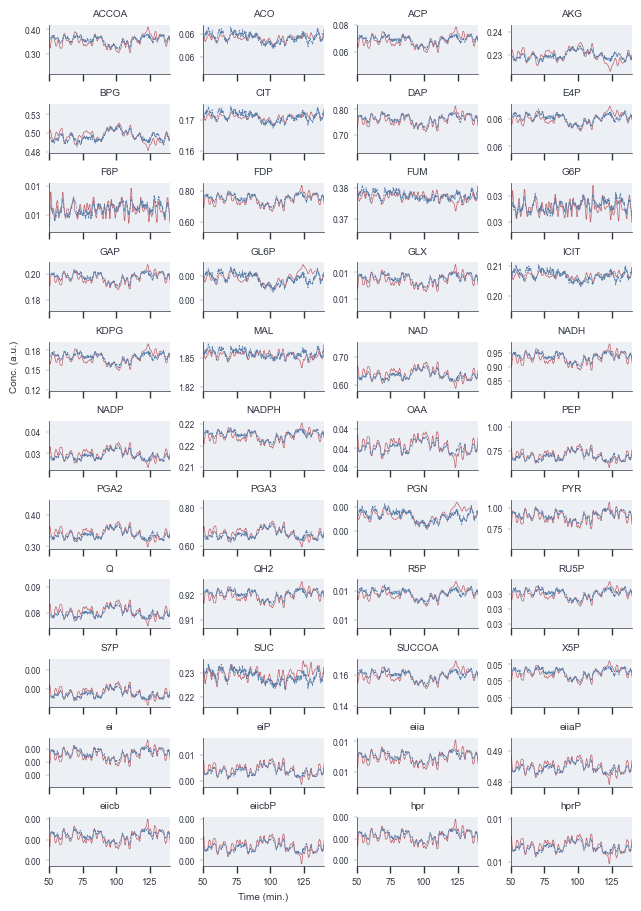

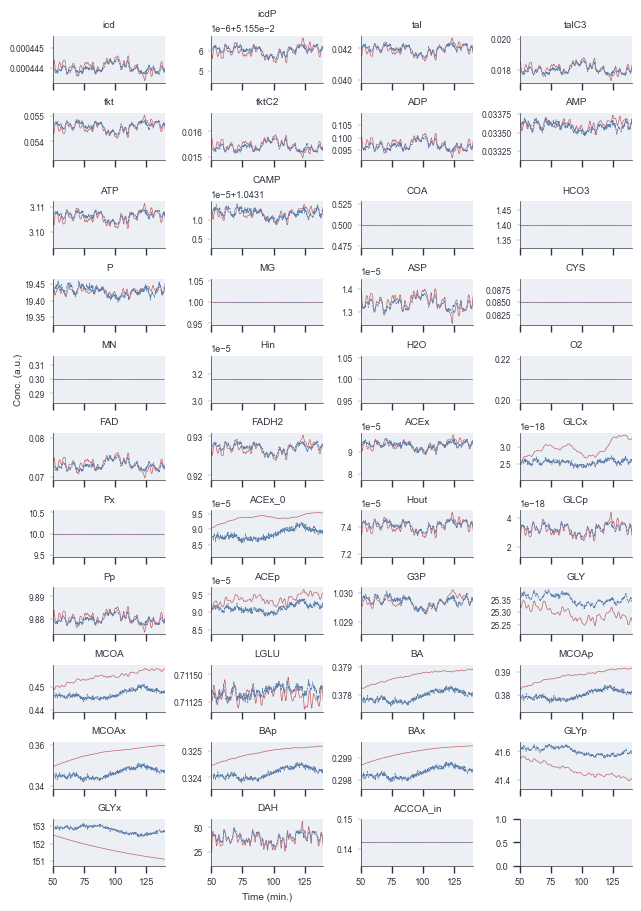

In [12]:
from matplotlib import ticker

SEL_labels = np.array(model.getStateIds()[:44])
SEL_label_idx = [model.getStateIds().index(l) for l in SEL_labels]
fig, axes = plt.subplots(11,4, figsize=(6.3,9), sharex=True, constrained_layout=True, 
                            gridspec_kw={'hspace': 0.1,}
                        )
axes = axes.flatten()


for i, (idx, l) in enumerate(zip(SEL_label_idx, SEL_labels)):
    axes[i].set_title(l)
    axes[i].plot(time_points[N_skip:N_test], data.values[N_skip:N_test][:,idx], color=f'C0', lw=0.5)
    axes[i].plot(time_points[N_skip+6:N_train+6], data_test[idx][:N_train-N_skip], color=f'C2', ls='dashed', lw=0.5)
    axes[i].plot(time_points[N_train+6:N_test+6], data_test[idx][N_train-N_skip:N_test], color=f'C8', ls='dashed', lw=0.5)
    axes[i].set_xlim(time_points[N_skip], time_points[N_test])
    axes[i].set_xlim(50, 140)
    axes[i].set_xlabel(None)
    axes[i].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    axes[i].tick_params(axis='y', width=0.2, length=2.5, labelsize=6)
    sns.despine()


axes[16].set_ylabel("Conc. (a.u.)")
axes[-3].set_xlabel("Time (min.)")

save_si("si_dynamics_predictions_a")

SEL_labels = np.array(model.getStateIds()[44:87])
SEL_label_idx = [model.getStateIds().index(l) for l in SEL_labels]
fig, axes = plt.subplots(11,4, figsize=(6.3,9), sharex=True, constrained_layout=True, 
                            gridspec_kw={'hspace': 0.1,}
                        )
axes = axes.flatten()

for i, (idx, l) in enumerate(zip(SEL_label_idx, SEL_labels)):
    axes[i].set_title(l)
    axes[i].plot(time_points[N_skip:N_test], data.values[N_skip:N_test][:,idx], color=f'C0', lw=0.5)
    axes[i].plot(time_points[N_skip+6:N_train+6], data_test[idx][:N_train-N_skip], color=f'C2', ls='dashed', lw=0.5)
    axes[i].plot(time_points[N_train+6:N_test+6], data_test[idx][N_train-N_skip:N_test], color=f'C8', ls='dashed', lw=0.5)
    axes[i].set_xlim(time_points[N_skip], time_points[N_test])
    axes[i].set_xlim(50, 140)
    axes[i].ticklabel_format(axis='y', style='sci')
    axes[i].set_xlabel(None)
    axes[i].tick_params(axis='y', width=0.2, length=2.5, labelsize=6)
    sns.despine()

axes[16].set_ylabel("Conc. (a.u.)")
axes[-3].set_xlabel("Time (min.)")

save_si("si_dynamics_predictions_b")


## Compare NMSE scores against linear predictor and plot

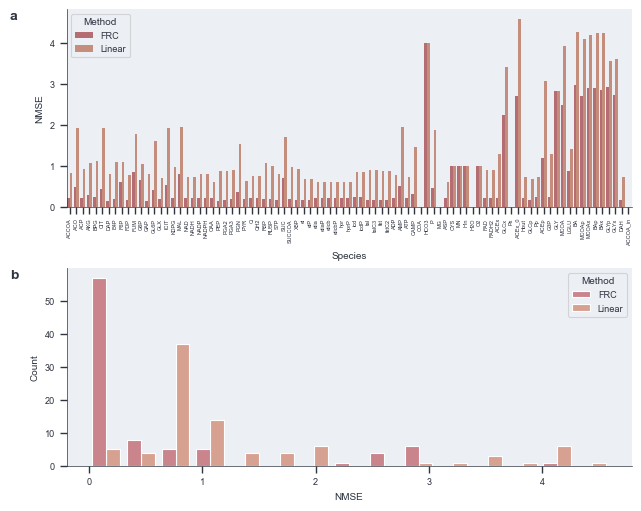

In [15]:
tests_df = pd.DataFrame({'id': model.getStateIds()[:87], 'FRC': MSE_tests, 'Linear': MSE_lin_tests})
tests_df = pd.melt(tests_df, id_vars='id', var_name="Method", value_name="NMSE")

fig, axes = plt.subplots(2, 1, figsize=(6.3, 5), constrained_layout=True)
sns.barplot(tests_df, ax=axes[0], x='id', y='NMSE', hue='Method', linewidth=0)
axes[0].tick_params(axis='x', rotation=90, labelsize=4)
axes[0].set_xlabel("Species")
sns.histplot(tests_df, ax=axes[1], x='NMSE', hue='Method', multiple="dodge", shrink=0.8)
sns.despine()
axes[0].text(-0.1, 0.95, 'a', transform=axes[0].transAxes, size=10, weight='bold')
axes[1].text(-0.1, 0.95, 'b', transform=axes[1].transAxes, size=10, weight='bold')
save_si("si_dynamics_errors")

## Plots figure 3c - Results Pyr., 3PG, AMP

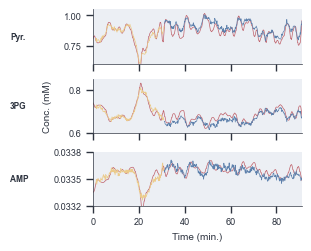

In [14]:
SEL_labels = ['PYR', 'PGA3', 'AMP']
SEL_label_idx = [model.getStateIds().index(l) for l in SEL_labels]
fig, axes = plt.subplots(3,1, figsize=(3.0, 2.4), sharex=True, constrained_layout=True, 
                        )
axes = axes.flatten()

for i, (idx, l) in enumerate(zip(SEL_label_idx, SEL_labels)):
    axes[i].plot(time_points[N_skip:N_test], data.values[N_skip:N_test][:,idx], color=f'C0', lw=0.5)
    axes[i].plot(time_points[N_skip+6:N_train+6], data_test[idx][:N_train-N_skip], color=f'C2', ls='solid', lw=0.5)
    axes[i].plot(time_points[N_train+6:N_test+6], data_test[idx][N_train-N_skip:N_test], color=f'C8', ls='solid', lw=0.5)
    axes[i].set_xlim(time_points[N_skip], time_points[N_test])
    sns.despine()
axes[1].set_ylabel("Conc. (mM)")
axes[1].yaxis.set_label_coords(-0.2, 0.5)

axes[2].set_xlabel("Time (min.)")
axes[0].set_ylim(0.6, 1.05)
axes[1].set_ylim(0.6, 0.85)
axes[2].set_ylim(0.0332, 0.0338)
axes[2].set_yticks([0.0332, 0.0335, 0.0338])
axes[0].text(-0.4, 0.5, 'Pyr.', transform=axes[0].transAxes, va='center', fontsize='small' , fontweight='bold')
axes[1].text(-0.4, 0.5, '3PG', transform=axes[1].transAxes, va='center', fontsize='small', fontweight='bold')
axes[2].text(-0.4, 0.5, 'AMP', transform=axes[2].transAxes, va='center', fontsize='small', fontweight='bold')

axes[2].set_xticks([20, 40, 60, 80, 100], [0, 20, 40, 60, 80])
axes[2].set_xlim(20, 51+60)

save_plot("dynamics_predictions")


## Plots figure 3d - Comparison plots

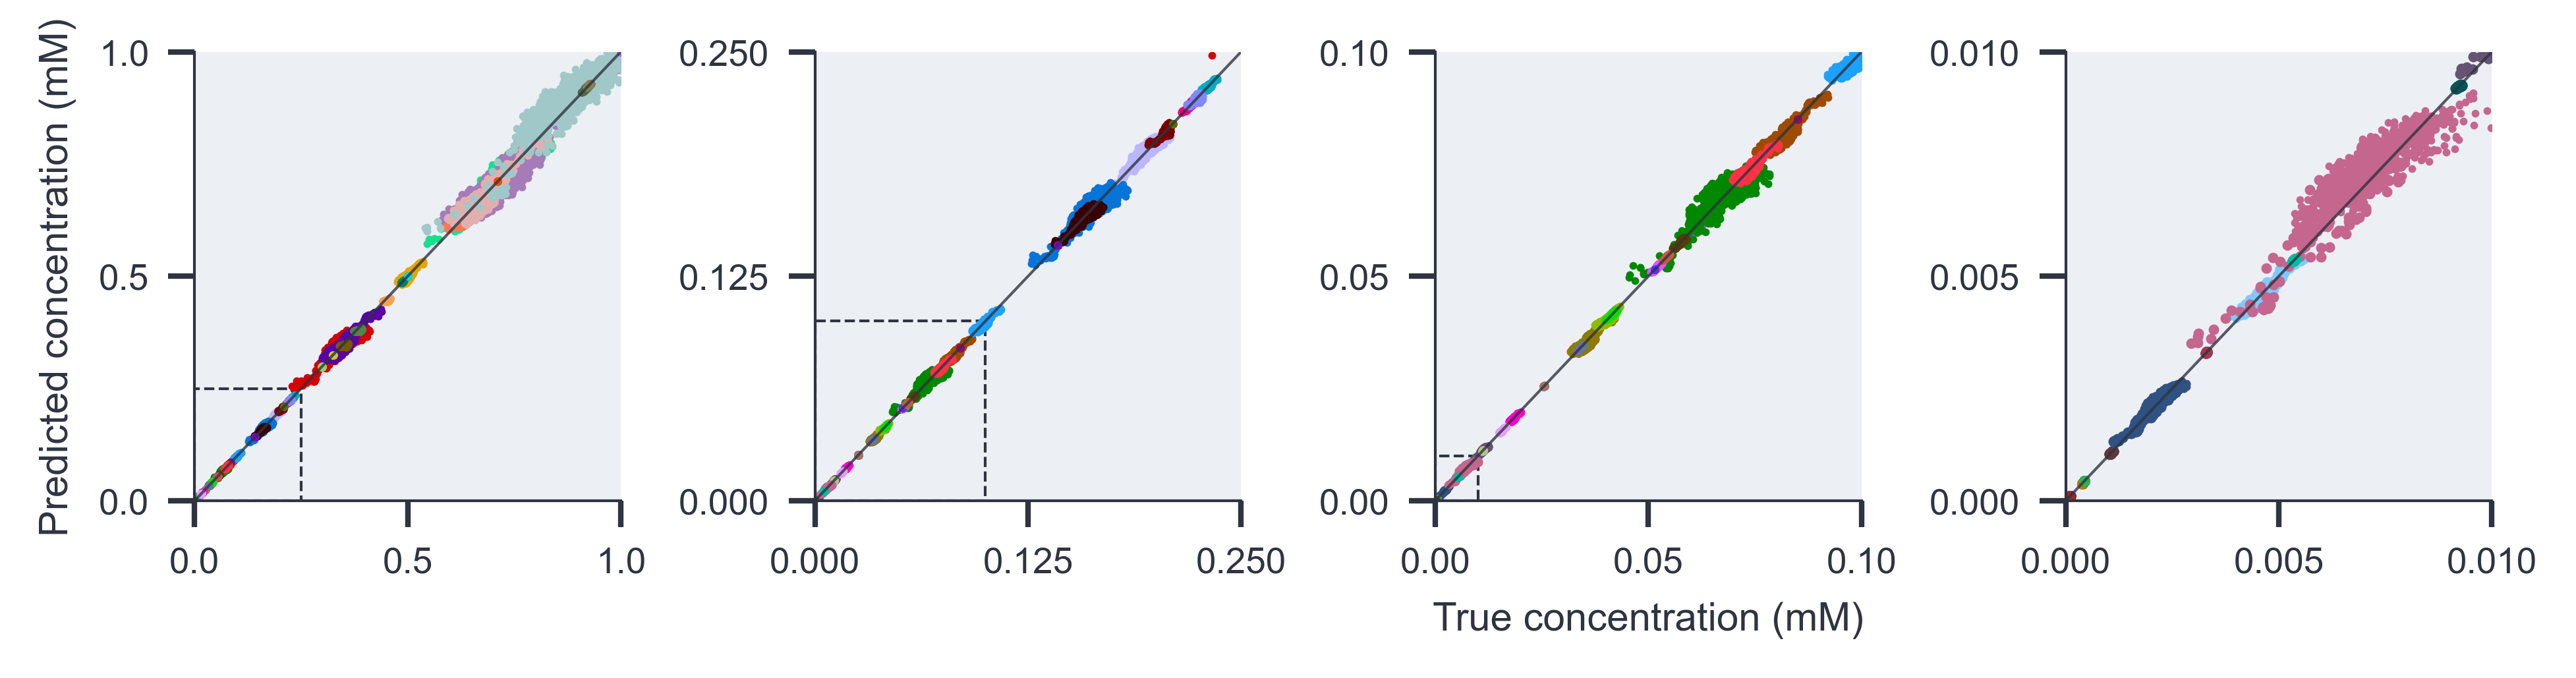

In [15]:
fig, axes = plt.subplots(1,4, figsize=(6.4,1.6), constrained_layout=True, 
                        dpi=600,
                        )
axes = axes.flatten()

from matplotlib.patches import Rectangle
axes[0].add_patch(Rectangle((0, 0), 0.25, 0.25, fill=True, ec='C9', lw=0.5, ls='--', facecolor='#eceff4'))
axes[1].add_patch(Rectangle((0, 0), 0.1, 0.1, fill=True, ec='C9', lw=0.5, ls='--', facecolor='#eceff4'))
axes[2].add_patch(Rectangle((0, 0), 0.01, 0.01, fill=True, ec='C9', lw=0.5, ls='--', facecolor='#eceff4'))

axes[0].plot([0,1],[0,1], color='C9', lw=0.5, alpha=0.8)
axes[1].plot([0, 1],[0, 1], color='C9', lw=0.5, alpha=0.8)
axes[2].plot([0,1e3],[0,1e3], color='C9', lw=0.5, alpha=0.8)
axes[3].plot([0,1e3],[0,1e3], color='C9', lw=0.5, alpha=0.8)

SEL_labels = np.array(model.getStateIds()[:87])
SEL_label_idx = [model.getStateIds().index(l) for l in SEL_labels]

MEAN = data.values[N_train:N_test].mean(axis=0)

for i, (idx, l) in enumerate(zip(SEL_label_idx, SEL_labels)):
    axes[0].scatter(data.values[N_skip+6:N_train+6][:,idx],data_test[idx][:N_train-N_skip], color=cc.glasbey_dark[i], lw=0, label=l, rasterized=True, s=2.0)
    axes[0].scatter(data.values[N_train+6:N_test+6][:,idx],data_test[idx][N_train-N_skip:N_test], color=cc.glasbey_dark[i], lw=0, rasterized=True, s=2.0)
    axes[1].scatter(data.values[N_skip+6:N_train+6][:,idx],data_test[idx][:N_train-N_skip], color=cc.glasbey_dark[i], lw=0, label=l, rasterized=True, s=2.0)
    axes[1].scatter(data.values[N_train+6:N_test+6][:,idx],data_test[idx][N_train-N_skip:N_test], color=cc.glasbey_dark[i], lw=0, rasterized=True, s=2.0)
    axes[2].scatter(data.values[N_skip+6:N_train+6][:,idx],data_test[idx][:N_train-N_skip], color=cc.glasbey_dark[i], lw=0, label=l, rasterized=True, s=2.0)
    axes[2].scatter(data.values[N_train+6:N_test+6][:,idx],data_test[idx][N_train-N_skip:N_test], color=cc.glasbey_dark[i], lw=0, rasterized=True, s=2.0)
    axes[3].scatter(data.values[N_skip+6:N_train+6][:,idx],data_test[idx][:N_train-N_skip], color=cc.glasbey_dark[i], lw=0.5, label=l, rasterized=True, s=2.0)
    axes[3].scatter(data.values[N_train+6:N_test+6][:,idx],data_test[idx][N_train-N_skip:N_test], color=cc.glasbey_dark[i], lw=0, rasterized=True, s=2.0)
axes[0].set_ylabel("Predicted concentration (mM)")
axes[2].set_xlabel("True concentration (mM)")

axes[0].set_xlim(0, 1.0)
axes[0].set_ylim(0, 1.0)
axes[1].set_xlim(0, 0.25)
axes[1].set_ylim(0, 0.25)
axes[2].set_xlim(0, 0.1)
axes[2].set_ylim(0, 0.1)
axes[3].set_xlim(0, 0.01)
axes[3].set_ylim(0, 0.01)

axes[0].set_xticks([0, 0.5, 1.0])
axes[0].set_yticks([0, 0.5, 1.0])
axes[1].set_xticks([0, 0.125, 0.25])
axes[1].set_yticks([0, 0.125, 0.25])
axes[2].set_xticks([0, 0.05, 0.1])
axes[2].set_yticks([0, 0.05, 0.1])
axes[3].set_xticks([0, 0.005, 0.01])
axes[3].set_yticks([0, 0.005, 0.01])

sns.despine()
save_plot('dynamics_score')
